In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'genre-classification-dataset-imdb:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1417162%2F2347441%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T093502Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab01a1ede53f175cc9a6c2f7e0a3cc79ad8d695d65e0fab9c3855608c178e6c4b9f7d7b8a8c7ebb3cbec53739814268faa7bdfb38dea190087477947afdfd7ed62301dcc3aa1b5a95136c03ffa1c9911dcaaee4891ff4bf84351a4fb4e601c3d0aaabeaaf0501434503aa18878f8a96503208bb0ff47ad950f7f1bd91f635362f814579f4aa97ccf5d5e8e8392fd12b9e18f7880d3f50a085036b353fce472979ab53129da2d01e89b69bb6636b5955ea12f021300d24d53f3bd17361c0198b71bf7fcecc922db7ce27e75d24015eef7397588b13d4de0b3b547eb97ece7bf26ccd3255c910aecd4b95e93cd49cd5f7da28070dbecf470e44217bb3142655ff8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 43729690 bytes downloaded
Downloaded and uncompressed: genre-classification-dataset-imdb
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
# linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [5]:
df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])
display(df.head())
print(df.shape)

<ipython-input-5-6f88286cddd4>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt",sep=':::', names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION'])


,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


(54214, 4)


import re
def clean_text(text):
    # Remove special characters, punctuation, and symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [6]:
df[0:1]

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...


In [7]:
df.drop(columns=['ID','TITLE'],inplace=True)

In [8]:
df.head()

,GENRE,DESCRIPTION
0,drama,Listening in to a conversation between his do...
1,thriller,A brother and sister with a past incestuous r...
2,adult,As the bus empties the students for their fie...
3,drama,To help their unemployed father make ends mee...
4,drama,The film's title refers not only to the un-re...


In [9]:
average_length = df['DESCRIPTION'].str.len().mean()

print(f"The average length of movie descriptions is: {average_length:.2f}")


The average length of movie descriptions is: 600.45


In [10]:
df['GENRE'].value_counts()

GENRE
 drama           13613
 documentary     13096
 comedy           7447
 short            5073
 horror           2204
 thriller         1591
 action           1315
 western          1032
 reality-tv        884
 family            784
 adventure         775
 music             731
 romance           672
 sci-fi            647
 adult             590
 crime             505
 animation         498
 sport             432
 talk-show         391
 fantasy           323
 mystery           319
 musical           277
 biography         265
 history           243
 game-show         194
 news              181
 war               132
Name: count, dtype: int64

In [11]:
# Ensure the genre names are in lowercase and stripped of leading/trailing spaces
df['GENRE'] = df['GENRE'].str.lower().str.strip()


In [12]:
genres_of_interest = ['drama', 'action', 'documentary', 'thriller', 'comedy']
filtered_df = df[df['GENRE'].isin(genres_of_interest)]

In [13]:
filtered_df['GENRE'].value_counts()

GENRE
drama          13613
documentary    13096
comedy          7447
thriller        1591
action          1315
Name: count, dtype: int64

In [14]:
sampled_df = filtered_df.groupby('GENRE').apply(lambda x: x.sample(n=1000, random_state=42)).reset_index(drop=True)

In [15]:
sampled_df.head()

,GENRE,DESCRIPTION
0,action,After the underground fight club was shut dow...
1,action,What can a group of idealists do to stop ramp...
2,action,"Set 18 months after movie ""Library Wars."" Aft..."
3,action,In homage to the action films of the early 19...
4,action,Burt meets Jack Costello after many years. Bu...


In [16]:
sampled_df['GENRE'].value_counts()

GENRE
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

In [17]:
sampled_df.shape

(5000, 2)

In [18]:
df=sampled_df

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
df['DESCRIPTION']=df['DESCRIPTION'].str.lower()

In [21]:
df.head()

,GENRE,DESCRIPTION
0,action,after the underground fight club was shut dow...
1,action,what can a group of idealists do to stop ramp...
2,action,"set 18 months after movie ""library wars."" aft..."
3,action,in homage to the action films of the early 19...
4,action,burt meets jack costello after many years. bu...


In [22]:
import re
def clean_text(text):
    # Remove special characters, punctuation, and symbols
    text = re.sub(r'[^\w\s]', '', text)
    return text
df['DESCRIPTION']=df['DESCRIPTION'].apply(clean_text)
df['DESCRIPTION']

0        after the underground fight club was shut dow...
1        what can a group of idealists do to stop ramp...
2        set 18 months after movie library wars after ...
3        in homage to the action films of the early 19...
4        burt meets jack costello after many years bur...
                              ...                        
4995     five friends take a weekend vacation to celeb...
4996     two convicts who have just escaped from priso...
4997     imagine that one day the police appear at you...
4998     the lifestyles of the rich and decadent dont ...
4999     a group of young boys trying to film a movie ...
Name: DESCRIPTION, Length: 5000, dtype: object

In [23]:
import nltk
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    tokens = nltk.word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

df['DESCRIPTION'] = df['DESCRIPTION'].apply(stem_text)

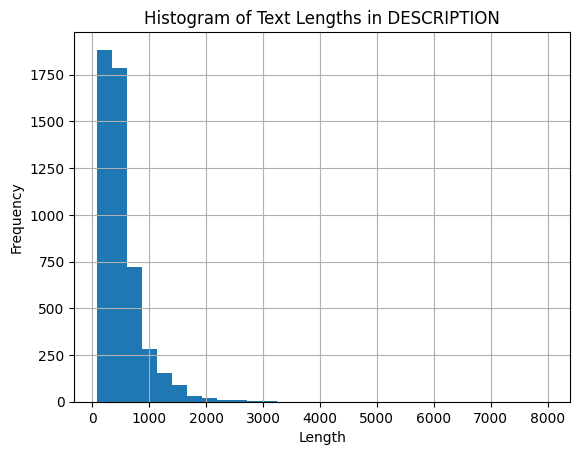

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'DESCRIPTION' is the column with text data
# Calculate the length of each text entry in the 'DESCRIPTION' column
df['length'] = df['DESCRIPTION'].str.len()

# Plot the histogram of the lengths
df['length'].hist(bins=30) # You can adjust the number of bins as needed

# Adding title and labels
plt.title('Histogram of Text Lengths in DESCRIPTION')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Display the histogram
plt.show()


In [25]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Assuming 'descriptions' is the column name containing the text data
# corpus = df['DESCRIPTION']

# # Create an instance of TfidfVectorizer
# vectorizer = TfidfVectorizer()

# # Fit and transform the corpus
# X = vectorizer.fit_transform(corpus)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['DESCRIPTION'], df['GENRE'], test_size=0.2, random_state=42)

Using Deep learning

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, df['GENRE'], test_size=0.2, random_state=42)


In [28]:
# from scipy.sparse import coo_matrix
# import tensorflow as tf

# # Convert Scipy sparse matrix to COO format
# coo = coo_matrix(X_train)
# coo2 = coo_matrix(X_test)
# # Create TensorFlow SparseTensor from COO
# tf_idf_matrix_train_tensor = tf.SparseTensor(indices=np.array([coo.row, coo.col]).T, values=coo.data, dense_shape=coo.shape)
# tf_idf_matrix_test_tensor = tf.SparseTensor(indices=np.array([coo2.row, coo2.col]).T, values=coo2.data, dense_shape=coo2.shape)

# # Reorder the SparseTensor
# tf_idf_matrix_train_ordered = tf.sparse.reorder(tf_idf_matrix_train_tensor)
# tf_idf_matrix_test_ordered = tf.sparse.reorder(tf_idf_matrix_test_tensor)

In [29]:
# tf_idf_matrix_train_ordered

In [30]:
# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert the target variable to one-hot encoded format
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train_encoded, num_classes=5)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=5)

In [31]:
# import gensim
# from gensim.models import KeyedVectors
# import gensim.downloader as api
# path = api.load("word2vec-google-news-300", return_path=True)
# print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


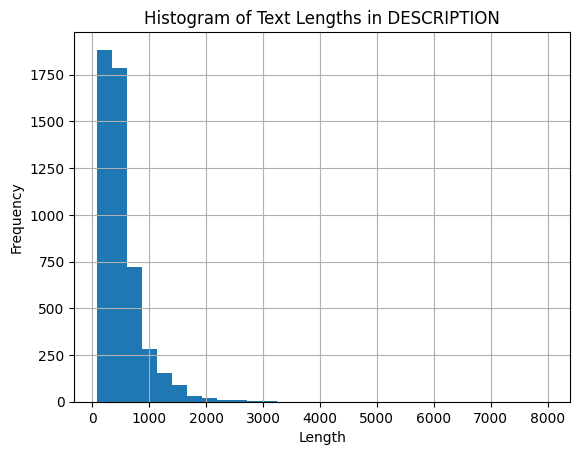

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'DESCRIPTION' is the column with text data
# Calculate the length of each text entry in the 'DESCRIPTION' column
df['length'] = df['DESCRIPTION'].str.len()

# Plot the histogram of the lengths
df['length'].hist(bins=30) # You can adjust the number of bins as needed

# Adding title and labels
plt.title('Histogram of Text Lengths in DESCRIPTION')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [34]:
average_length = df['DESCRIPTION'].str.len().mean()

print(f"The average length of movie descriptions is: {average_length:.2f}")


The average length of movie descriptions is: 527.45


In [35]:
unique_words = len(set(df['DESCRIPTION'].sum().split()))
print("Number of unique words:", unique_words)


Number of unique words: 31660


In [43]:
MAX_LENGTH = 500
VECTOR_SIZE = 300

In [49]:
def vectorize_data(data, model):
    vectors = []
    padding_vector = [0.0] * VECTOR_SIZE

    for data_point in data:
        data_point_vectors = []
        count = 0

        tokens = data_point.split()

        for token in tokens:
            if count >= MAX_LENGTH:
                break
            if token in model.key_to_index:  # Changed from model.wv.key_to_index
                data_point_vectors.append(model[token])  # Changed from model.wv[token]
            count += 1

        # Padding the remaining vectors if the data point is shorter than MAX_LENGTH
        data_point_vectors += [padding_vector] * (MAX_LENGTH - len(data_point_vectors))

        vectors.append(data_point_vectors)

    return vectors


In [37]:
!pip install gensim

In [38]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-04-06 16:00:41--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-06 16:00:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-04-06 16:03:20 (5.18 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [39]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = 'glove.6B.100d.txt'
model_file = 'glove.6B.100d.gensim.txt'

glove2word2vec(glove_file, model_file)

<ipython-input-39-a833276ff74b>:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, model_file)


(400000, 100)

In [40]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format(model_file, binary=False)

In [50]:
x_train_vectorized = vectorize_data(X_train,word2vec_model)
x_test_vectorized = vectorize_data(X_test,word2vec_model)

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Get the vocabulary size and vector size
vocab_size = len(word2vec_model.index_to_key)
vector_size = word2vec_model.vector_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=vector_size,
                    weights=[word2vec_model.vectors],
                    input_length=MAX_LENGTH,
                    trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train_vectorized, y_train_encoded,
          validation_data=(x_test_vectorized, y_test_encoded),
          epochs=10, batch_size=32)

In [ ]:
loss, accuracy = model.evaluate(x_test_vectorized, y_test_encoded)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

In [34]:
# import gensim.downloader as api

# # Load the GLoVE embeddings
# glove_model = api.load("glove-wiki-gigaword-100",return_path=True)

# # Print the path to the downloaded model
# print(glove_model)


/root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz


In [41]:
# from gensim.models import KeyedVectors

# # Ensure the path to the GLoVE file is correct and contains 100-dimensional vectors
# glove_file = '/root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz'

# # Load the GLoVE vectors directly, specifying the correct vector size
# word2vec_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# # Verify the vector size
# print(word2vec_model.vector_size) # Should print 100


In [ ]:
# model=KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz',binary=True)
# word2vec_model = KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)


In [ ]:
# FILTERS=8
# KERNEL_SIZE=3
# HIDDEN_LAYER_1_NODES=10
# HIDDEN_LAYER_2_NODES=5
# DROPOUT_PROB=0.35
# NUM_EPOCHS=10
# BATCH_SIZE=64

In [ ]:
# from keras.preprocessing.sequence import pad_sequences

# padded_train_data = pad_sequences(tf_idf_matrix_train_ordered, maxlen=average_length, padding='post', truncating='post', value=0)
# padded_test_data = pad_sequences(tf_idf_matrix_test_ordered, maxlen=average_length, padding='post', truncating='post', value=0)


In [41]:

for i, vec in enumerate(x_train_vectorized):
 if len(vec) != MAX_LENGTH:
  print(i)


In [ ]:
# from gensim.models import KeyedVectors
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

# # Load the pre-trained word2vec model

# # Get the vocabulary size and vector size
# vocab_size = len(word2vec_model.index_to_key)
# vector_size = word2vec_model.vector_size

# # Create the model
# model = Sequential()
# model.add(Embedding(input_dim=vocab_size,
#                     output_dim=vector_size,
#                     weights=[word2vec_model.vectors],
#                     input_length=MAX_LENGTH,
#                     trainable=False))
# model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(5, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])